## SUPER RL BROS DEMO

Hello, and welcome to our demo of our project. Here we have a variety of heuristic models which can be tested on a series of enviroments.

The models we have to choose from are as follow:

    - Base Model (1-1, 1-2, 1-4)
    - Base Model + (Grad Clipping, Tanh Activation, Orthagonal Initialization) (1-1, 1-2, 1-4)
    - Base Model + (Grad Clipping, Tanh Activation, Orthagonal Initialization) + (Annealing )(1-1, 1-2, 1-4)
    - Base Model + (Grad Clipping, Tanh Activation, Orthagonal Initialization) + (Value Clip)(1-1, 1-2, 1-4)
    - Base Model + (Grad Clipping, Tanh Activation, Orthagonal Initialization) + (Reward Clip)(1-1, 1-2, 1-4)
    - Base Model + (Grad Clipping, Tanh Activation, Orthagonal Initialization) + (RND)(1-1, 1-2, 1-4)
    - FINAL MODEL (All heuristics-Reward Clip) (All levels excluding the final)

**Note: You will need these models installed and have the files extracted to the project directory:** 
https://drive.google.com/file/d/1wM_0wbGk4SYw_vv3fa41L0gug_JomYsp/view?usp=sharing

To train these models, check train.ipnyb

First, we will setup some methods which will be useful for evaluation and recording:

In [ ]:
## YOU MUST RUN THIS IN PYTHON 3.8.1
!pip install gym==0.21.0
!pip install -qq gym-super-mario-bros
!pip -qq install stable-baselines3==1.6.0
!pip install opencv-python
!pip install imageio-ffmpeg

In [4]:
from env import get_env
import env
from matplotlib import pyplot as plt
from stable_baselines3 import PPO
from gym.wrappers import RecordVideo

In [5]:
def record(name, episode_number, stages, version = 'SuperMarioBrosRandomStages-v1'):

    '''
    get the ENV and the policy
    '''
    env = get_env(stages, stage_name = version)
    rewards = []
    model = PPO.load(name+"/best_model_" + str(episode_number) + ".zip")
    state = env.reset()
    env = RecordVideo(env, 'video', lambda x: True)
    done = False
    cum_reward = 0

    
    while cum_reward < 10000:
        action, _ = model.predict(state)
        state, reward, done, info = env.step(action)
        env.render()
        cum_reward+=reward
        
    env.close()
    return cum_reward
    
    
def evaluate(name, episode_number, stages, num_episodes = 100, version = 'SuperMarioBrosRandomStages-v3'):

    '''
    get the ENV and the policy
    '''
    env = get_env(stages, stage_name = version)
    f = open(name+"_win_rate", "a")

    rewards = []
    model = PPO.load(name+"/best_model_" + str(episode_number) + ".zip")
    
    state = env.reset()
    done = False
    plays = 0
    wins = 0
    
    cum_reward = 0
    
    while plays < num_episodes:
        action, _ = model.predict(state)
        state, reward, done, info = env.step(action)
        cum_reward += reward

        if done or info[0]["flag_get"]:
            state = env.reset() 
            if info[0]["flag_get"]:
                wins +=1
            plays += 1
            
            rewards += [cum_reward]
            cum_reward =  0

    print('Avg Reward:', sum(rewards) / len(rewards))
            
    return rewards, wins/(num_episodes/100)

### RECORD AGENTS

The following cells will allow you to run a pretrained model, and record the output, such that you can view the agents performance. This by default is set to train on the final agent.

The parameters are as follows:
- MODEL NAME: this is the name of the folder the PPO has saved in
- EPISODE NUMBER: this is the version of the model you wish to use, in our example they come in increments of 10000
- RECORD LEVELS: this is the levels that the agent should be recorded on
- GAME VERSION: this is the version of the game we choose to run the agent on (use v1 for final model, v3 for other models)

In [ ]:
## Record script
RECORD_LEVELS = env.TRAIN_STAGE_FULL ## for agents other than final model, use env.VAL_STAGES_REDUCED
MODEL_NUMBER = 5920000
MODEL_NAME = './FinalModelVC'
GAME_VERSION = 'SuperMarioBrosRandomStages-v1'

record(name = MODEL_NAME, episode_number = MODEL_NUMBER, stages = RECORD_LEVELS, version = GAME_VERSION)

/usr/local/lib/python3.8/dist-packages/gym/wrappers/record_video.py:41: UserWarning: WARN: Overwriting existing videos at /home/ktnelson/MarioRL/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
D3D12: Removing Device.


### Evaluate Agents

The following scripts allow you to perform evaluations on our agent, please note this assumes that all of the models from the google drive have been properly imported.

In [14]:
reward = {}
reward['Base Model'] = evaluate('./Base', 460000, stages = env.VAL_STAGE_REDUCED, num_episodes = 25)[0]
reward['Improved Base Model'] = evaluate('./ImprovedBase', 500000, stages = env.VAL_STAGE_REDUCED, num_episodes = 25)[0]
reward['Value Clipping'] = evaluate('./ValueClip', 470000, stages = env.VAL_STAGE_REDUCED, num_episodes = 25)[0]
reward['LR Annealing'] = evaluate('./Annealing', 470000, stages = env.VAL_STAGE_REDUCED, num_episodes = 25)[0]
reward['Random Network Distillation'] = evaluate('./Intrins', 470000, stages = env.VAL_STAGE_REDUCED, num_episodes = 25)[0]
reward['Reward Clipping (15)'] = evaluate('./RewardClip', 470000, stages = env.VAL_STAGE_REDUCED, num_episodes = 25)[0]

GOAL
GOAL
Avg Reward: [454.78003]
Avg Reward: [286.21594]


##### Histogram Plots

In [18]:
from matplotlib import pyplot as plt
import numpy as np
colors = ['r', 'g' ,'b', 'p']
def plot_histogram(keys):
    data = [[x.item() for x in reward[key]] for key in keys]
    for x, k, c in zip(data, keys, colors):
        plt.hist(x, label = k, range=(0,1000), alpha = 0.5, bins = 10)
    plt.xlabel("Reward")
    plt.legend()
    plt.show()

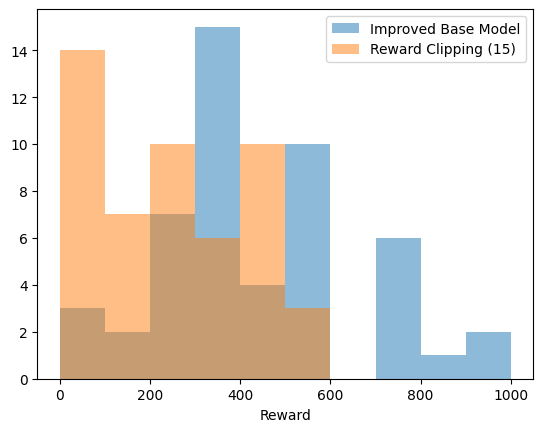

In [31]:
plot_histogram(['Improved Base Model', 'Reward Clipping (15)'])

##### Full Plot Comparison

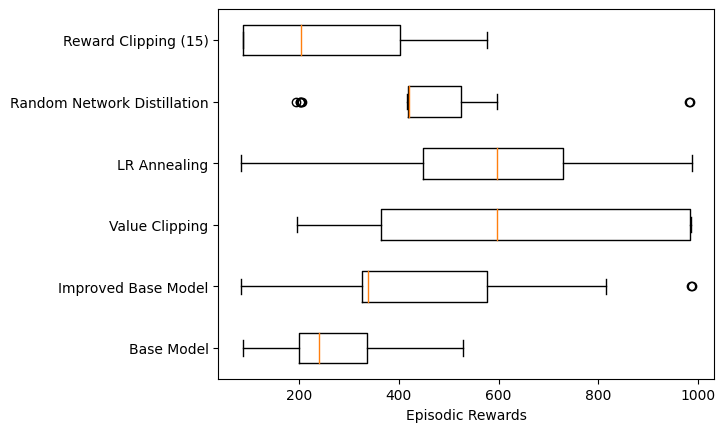

In [33]:
plt.boxplot([[x.item() for x in reward[key]] for key in reward.keys()], labels = list(reward.keys()), vert = False)
plt.xlabel('Episodic Rewards')
plt.show()

##### Extra: Different Reward Clip Comparison

In [34]:
reward['Reward Clipping (15)'] = evaluate('./RewardClip', 470000, stages = env.VAL_STAGE_REDUCED, num_episodes = 25)[0]
reward['Reward Clipping (25)'] = evaluate('./RewardClip25', 470000, stages = env.VAL_STAGE_REDUCED, num_episodes = 25)[0]
reward['Reward Clipping (50)'] = evaluate('./RewardClip50', 470000, stages = env.VAL_STAGE_REDUCED, num_episodes = 25)[0]

Avg Reward: [228.05595]
Avg Reward: [286.91193]
Avg Reward: [268.97998]


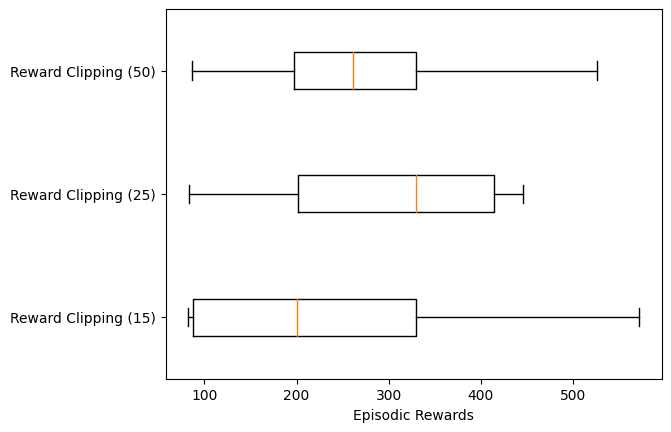

In [36]:
clip_eval = {'Reward Clipping (15)' : reward['Reward Clipping (15)'], 'Reward Clipping (25)' : reward['Reward Clipping (25)'], 'Reward Clipping (50)' : reward['Reward Clipping (50)']}

plt.boxplot([[x.item() for x in clip_eval[key]] for key in clip_eval.keys()], labels = list(clip_eval.keys()), vert = False)
plt.xlabel('Episodic Rewards')
plt.show()

### REPRODUCING THE FINAL MODEL EVALUATION

The following Cell will allow you to reproduce the evaluation of the final model displayed in the report

In [ ]:
dic = {}
dic_w = {}
for stage, val_marker in zip( env.TRAIN_STAGE_FULL+env.VAL_STAGE_FULL, ['(tr)']*len(env.TRAIN_STAGE_FULL)+ ['(val)']*len(env.VAL_STAGE_FULL)):
    rew, wr = evaluate('./FinalModelVC', 5920000, stages = env.TRAIN_STAGE_FULL, numEpisodes = 25)
    dic[f'{stage} {val_marker}'] = rew
    dic_w[f'{stage} {val_marker}'] = wr

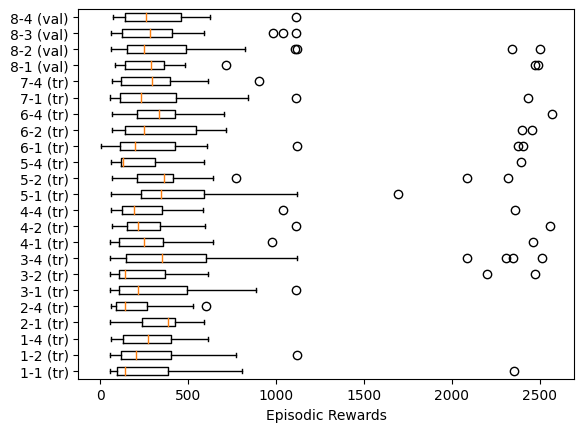

In [9]:

plt.boxplot([[x.item() for x in dic[key]] for key in dic.keys()], labels = list(dic.keys()), vert = False)
plt.xlabel('Episodic Rewards')
plt.show()